2025-07-17 15:14:15 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-07-17 15:14:15 INFO     xscen.config    Updated the config with ../config_obs.yml.


Processing: pr_mean_annual_rmse


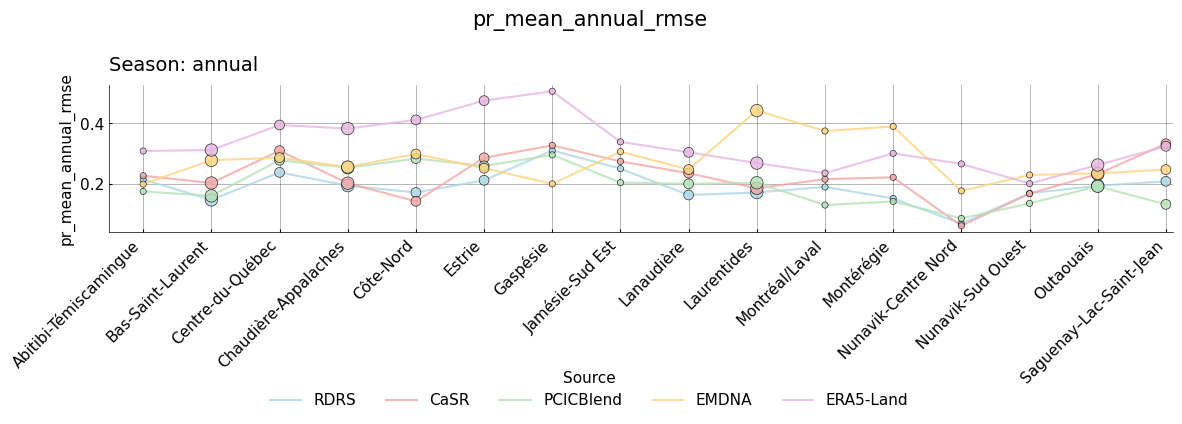

Processing: pr_mean_seasonal_rmse


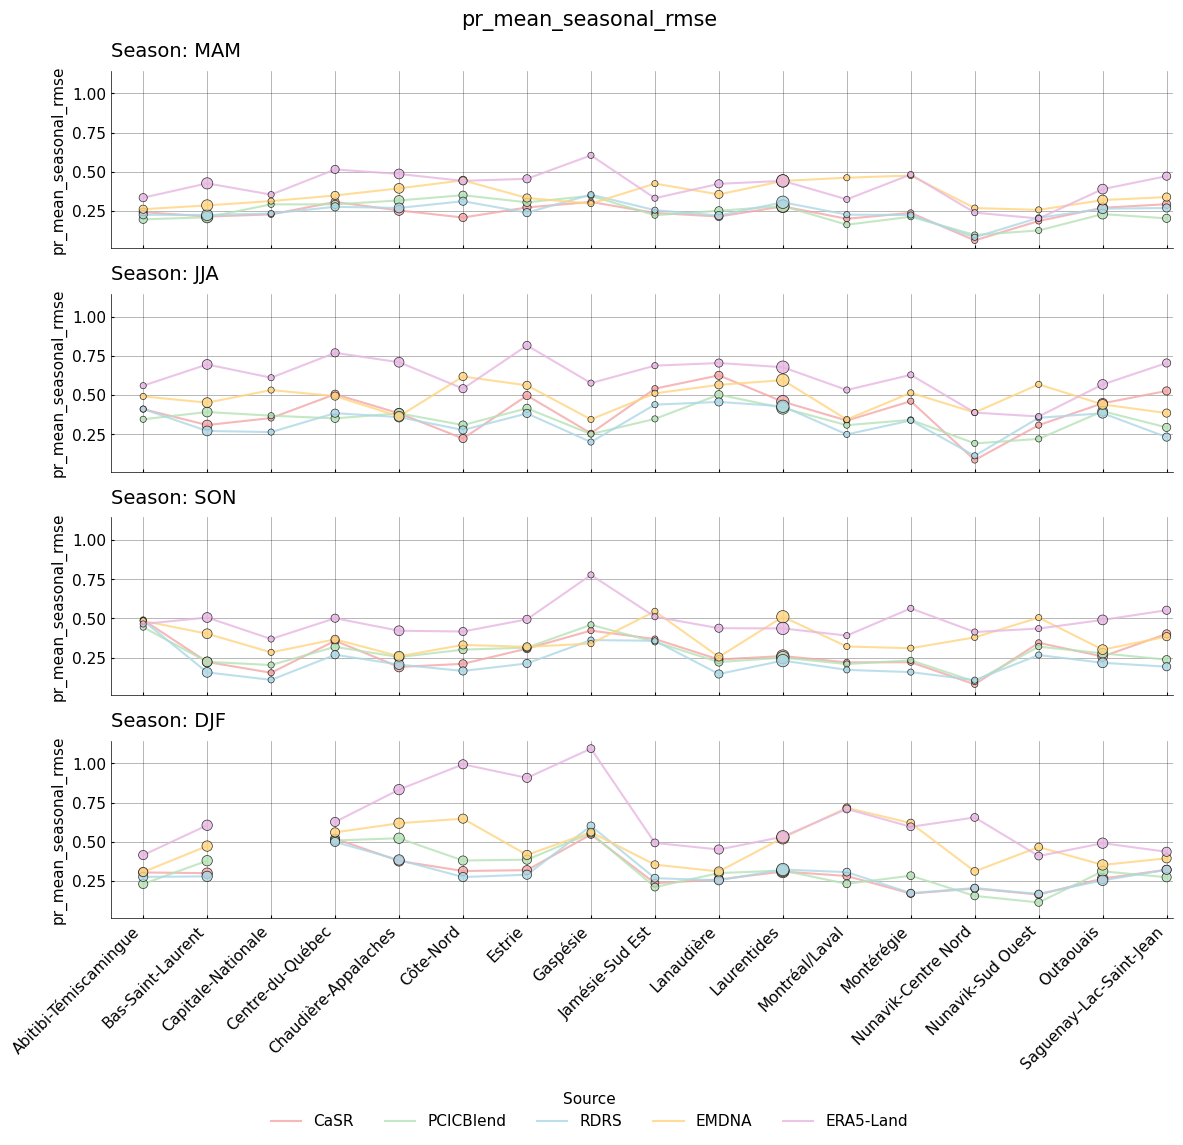

Processing: tg_mean_annual_rmse


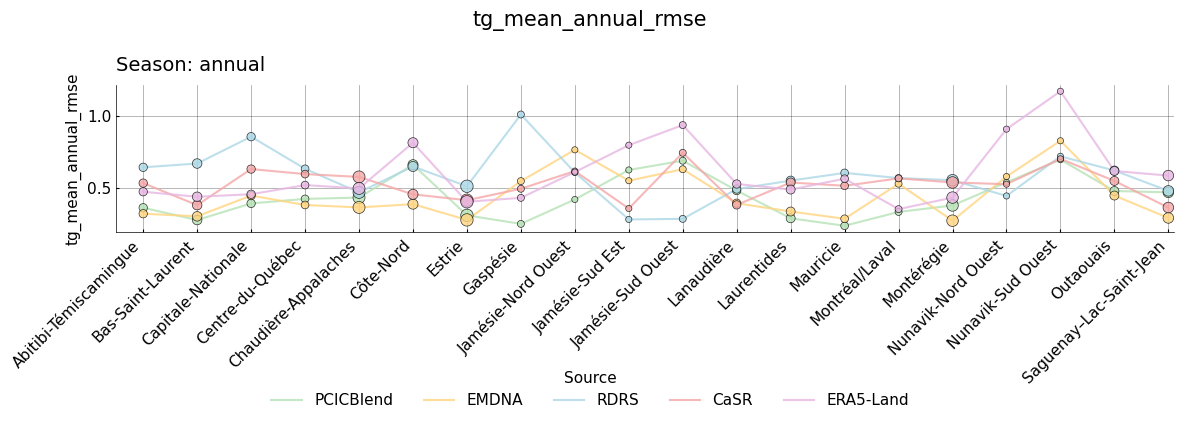

Processing: tg_mean_seasonal_rmse


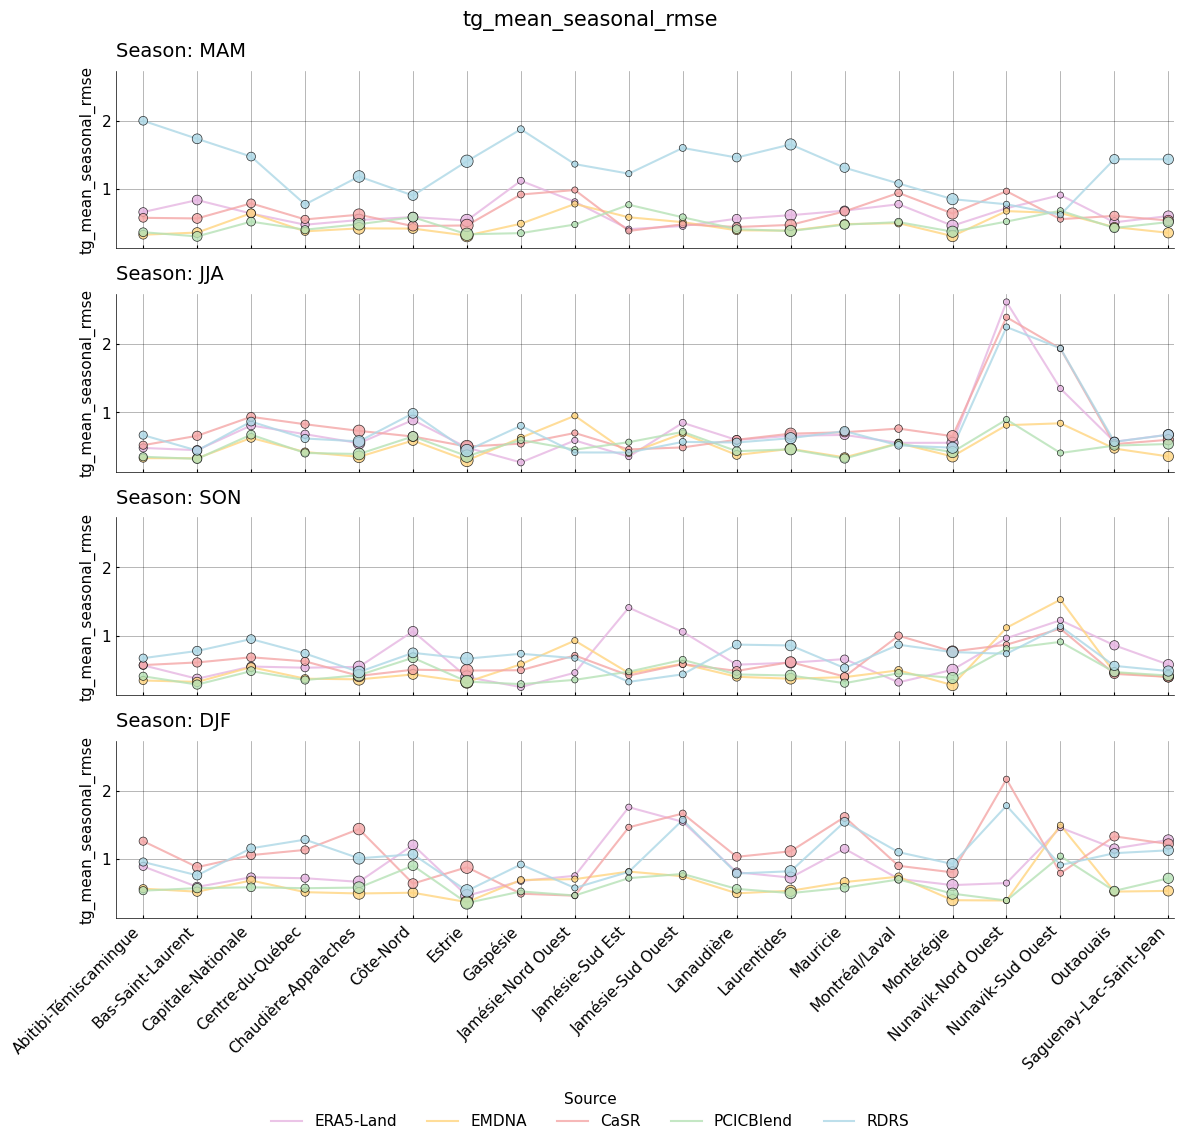

In [51]:
import xscen as xs
from xscen.config import CONFIG
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# === Setup ===
xs.load_config("../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True)
pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])

# Define source colors
SOURCE_COLORS = {
    "EMDNA": "#FFD580",
    "PCICBlend": "#B6E2B6",
    "RDRS": "#ADD8E6",
    "ERA5-Land": "#E6B6E2",
    "CaSR": "#F4A6A6"
}

# Get list of spatial_mean variables
df = pcat.df
df = df[df["processing_level"] == "spatial_mean"]
variables = sorted({v for group in df["variable"].unique() for v in group})

# Loop over each variable to plot
for var in variables:
    print(f"Processing: {var}")
    try:
        ds_all = pcat.search(processing_level="spatial_mean", variable=var).to_dataset().compute()
    except Exception as e:
        print(f"Failed to load dataset for {var}: {e}")
        continue

    if var not in ds_all:
        print(f"Variable '{var}' not found in dataset.")
        continue

    # === Plot setup: Seasons as rows ===
    seasons = ds_all["season"].values
    n_rows = len(seasons)
    fig_height = 2.75 * n_rows if n_rows > 1 else 4
    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=1,
        figsize=(12, fig_height),
        sharex=True
    )

    if n_rows == 1:
        axes = [axes]

    regions = ds_all["region"].values
    sources = ds_all["source"].values

    # Compute consistent y-limits across all subplots
    da_all = ds_all[var]
    ymin = float(da_all.min())
    ymax = float(da_all.max())
    y_pad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0

    for i, season in enumerate(seasons):
        ax = axes[i]
        ds = ds_all.sel(season=season)
        da = ds[var]  # shape: (source, region)
        nstation_season = ds["nstation"].values  # shape: (region,)

        # Normalize station counts to marker sizes
        size_min, size_max = 30, 120
        sizes = np.full_like(nstation_season, size_min, dtype=float)
        valid = np.isfinite(nstation_season)
        n_min, n_max = np.nanmin(nstation_season), np.nanmax(nstation_season)
        if n_max > n_min:
            sizes[valid] = size_min + (nstation_season[valid] - n_min) / (n_max - n_min) * (size_max - size_min)

        for source in sources:
            y = da.sel(source=source).values
            color = SOURCE_COLORS.get(source, None)

            # Line without markers
            ax.plot(regions, y, color=color, label=source, alpha=0.8)

            # Scatter markers sized by station count
            x = np.arange(len(regions))
            ax.scatter(x, y, s=sizes/1.5, color=color, edgecolor='black', linewidth=0.5, zorder=3, alpha=0.8)

        ax.set_ylabel(var)
        ax.set_title(f"Season: {season}", loc='left')
        ax.set_ylim(ymin - y_pad, ymax + y_pad)
        ax.grid(True)

    # Bottom x-axis labels
    axes[-1].set_xticks(np.arange(len(regions)))
    axes[-1].set_xticklabels(regions, rotation=45, ha='right')
    axes[-1].set_xlim(-0.5, len(regions) - 0.9)

    # Shared legend at bottom
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Source", loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05))

    # Title and layout
    fig.suptitle(var, fontsize=15, y=0.98)
    fig.subplots_adjust(bottom=0.15, top=0.9)
    plt.tight_layout()
    plt.show()
